<a href="https://colab.research.google.com/github/AntoninaKOR/RL/blob/main/SARSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Downloading and Importing

In [ ]:
!apt-get install swig
!pip install Image
!pip install autorom
!pip install shimmy
!pip install 'gymnasium[atari]'

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  swig4.0
Suggested packages:
  swig-doc swig-examples swig4.0-examples swig4.0-doc
The following NEW packages will be installed:
  swig swig4.0
0 upgraded, 2 newly installed, 0 to remove and 49 not upgraded.
Need to get 1,116 kB of archives.
After this operation, 5,542 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig4.0 amd64 4.0.2-1ubuntu1 [1,110 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig all 4.0.2-1ubuntu1 [5,632 B]
Fetched 1,116 kB in 0s (4,327 kB/s)
Selecting previously unselected package swig4.0.
(Reading database ... 123629 files and directories currently installed.)
Preparing to unpack .../swig4.0_4.0.2-1ubuntu1_amd64.deb ...
Unpacking swig4.0 (4.0.2-1ubuntu1) ...
Selecting previously unselected package swig.
Preparing to unpack .../swig_4.0.2-1ubu

In [ ]:
import gymnasium as gym
import numpy as np
import ale_py
import shimmy
from torch.distributions import Categorical
import torch
import torch.nn as nn
import torch.optim as optim
from collections import namedtuple, deque

import matplotlib.pyplot as plt
%matplotlib inline

import sys

from tqdm import trange, tqdm

In [ ]:
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "cpu"
)

#Intro
There is a **SARSA** algorithm with policy function with based on **Alexnet** (but with other sizes of out_channels and without one conv layer). The algorithm works on MsPacman environment from Gymnasium lib.

The **task** is to implement the algorithm and train the model.

Information is taken from  the book "Foundations of Deep Reinforcement Learning: Theory and Practice in Python" (Addison-Wesley Data & Analytics Series) and same parts of the code is taken with changes from https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

#Env

Initial observation:


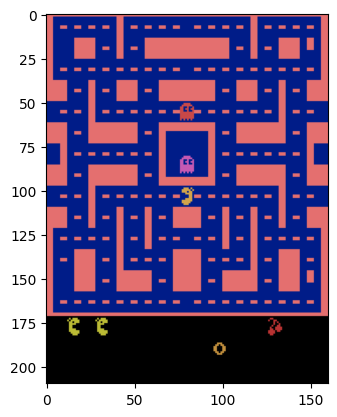

In [ ]:
env = gym.make("ALE/MsPacman-v5",  render_mode="rgb_array", obs_type="grayscale")
env.reset()
print("Initial observation:")
plt.imshow(env.render())

#Memory
There is a deque where is placed batch of pairs (s, a, s', a').

In [ ]:
Transition = namedtuple('Transition', ('state', 'action', 'reward',  'next_action', 'next_state'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

#Algorithm

We use algorithm from the book "Foundations of Deep Reinforcement Learning: Theory and Practice in Python" (Addison-Wesley Data & Analytics Series).

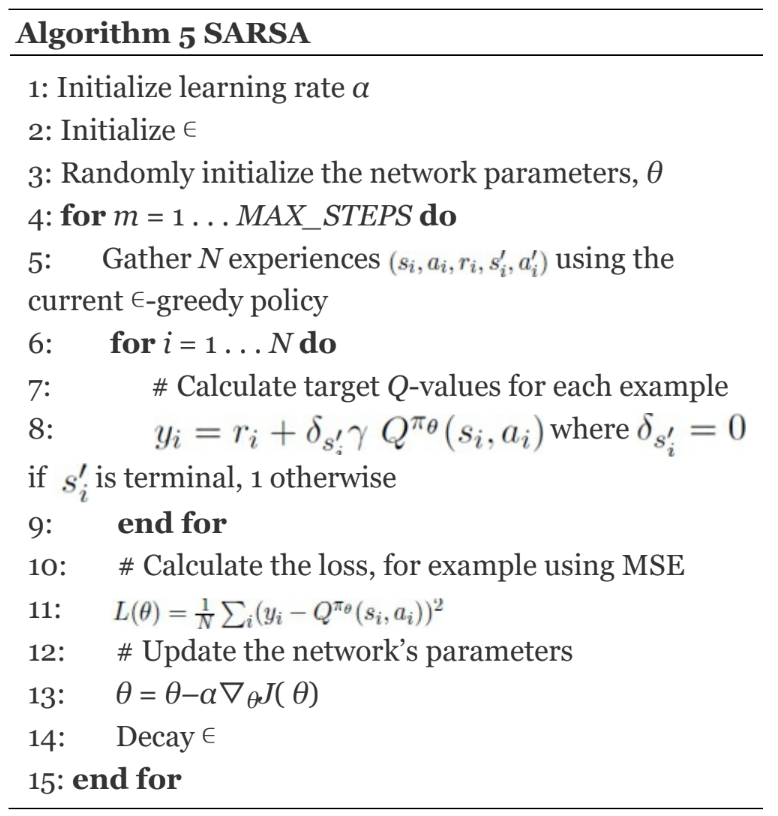

#Q-value model

Here we use DL for Q-value, not a table.

In [ ]:
# Q-value model
class   Q(nn.Module):
  def __init__(self, in_dim,  gamma, dropout: float = 0.5):
    super(Q, self).__init__()
    layers = [ # input (1, 172, 160)
               nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3), #  (6, 170, 158)
               nn.ReLU(inplace=True),
               nn.MaxPool2d(kernel_size=2), # ( 6, 104, 79)

               nn.Conv2d(6, 18, kernel_size=5, padding=2), #(18, 104, 79)
               nn.ReLU(inplace=True),
               nn.MaxPool2d(kernel_size=3, stride=2), #(18, 51, 39)

               nn.Conv2d(18, 64, kernel_size=3, padding=1), #(64, 51, 39)
               nn.ReLU(inplace=True),
               nn.MaxPool2d(kernel_size=3, stride=2), #(64, 24, 18)

               nn.AdaptiveAvgPool2d((6, 6)),

               nn.Flatten(0),

               nn.Dropout(p=dropout),
               nn.Linear(64 * 6 * 6, 1152),
               nn.ReLU(inplace=True),

               nn.Dropout(p=dropout),
               nn.Linear(1152, 64),
               nn.Linear(64,out_features = 5)
               ]

    self.model = nn.Sequential(*layers)
    self.gamma = gamma
    self.train()

  def forward(self, x):
    pdparam = self.model(x)
    return pdparam



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



# $ \epsilon $ -greedy policy


This function sometimes choose random action intead of the best. So, the agent better discover the enviroment.

In [ ]:
def policy_greedy(state, epsilon , Q):
  if epsilon > np.random.rand(): #np.random.rand() returns random samples from a uniform distribution over [0, 1).
    return torch.tensor([[env.action_space.sample()]], device=device)
  else:
    return Pi(state, Q)
def Pi(state, Q):
  return Q(state).max(0).indices.view(1, 1) #return action with best reward

#Train function

In [ ]:
def train (self):
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-terminal states and concatenate the batch elements
    # It is delta from the algorithm.
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    #non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    next_state_batch = torch.cat(batch.next_state)
    next_action_batch = torch.cat(batch.next_action)

    # Compute Q(s, a)
    q_preds = self(state_batch)
    state_action_values = q_preds.gather(1, action_batch)

    # Compute Q(s', a')
    next_q_preds = self(next_state_batch[non_final_mask])
    act_next_q_preds = next_q_preds.gather(1, next_action_batch)

    # Compute target Q-value
    y = reward_batch + self.gamma*act_next_q_preds

    # Compute loss
    loss = nn.MSELoss(reduction= 'mean')
    q_loss = loss(q_preds, y)

    # Optimize the model
    optimizer.zero_grad()
    q_loss.backward()
    optimizer.step()

#Main loop

In [68]:
BATCH_SIZE = 2000
GAMMA = 0.99
EPS = 0.5
LR = 1e-3
NUM_BATCHES = 10
N_RANDOM_MOVES = 50
N = 200 # number of epochs
rewards=[]
steps=[]

# Get number of actions from gym action space
n_actions = 5

Q_net = Q(n_actions, GAMMA).to(device)

optimizer = optim.AdamW(Q_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(BATCH_SIZE)


for i_episode in trange(N, file=sys.stdout):
    st =0
    rew = 0
    for i_batch in range(NUM_BATCHES):
      state, info = env.reset()
      for i in range(N_RANDOM_MOVES):
        action = env.action_space.sample()
        new_s, reward, terminated, truncated, _ = env.step(action)
      state = torch.tensor(new_s, dtype=torch.float32, device=device).unsqueeze(0)
      for t in range(BATCH_SIZE):
          action = policy_greedy(state ,EPS, Q_net)
          new_s, reward, terminated, truncated, _ = env.step(action.item())
          rew+=reward
          reward = torch.tensor([reward], device=device)
          done = terminated or truncated

          if terminated:
              next_state = None
              next_action= None
          else:
              next_state = torch.tensor(new_s, dtype=torch.float32, device=device).unsqueeze(0)
              next_action = policy_greedy(state, EPS, Q_net)

          # Store the transition in memory
          memory.push(state, action, reward, next_state, next_action)

          # Move to the next state
          state = next_state

          if done:
            st += t+1.
            break

        # Perform one step of the optimization (on the policy network)
      Q_net.train()
    rewards.append(rew/BATCH_SIZE)
    steps.append( st/BATCH_SIZE)
    tqdm.write(f'Episode {i_episode}, count of steps:{st/NUM_BATCHES}, total_reward:{rew/NUM_BATCHES}')


Episode 0, count of steps:534.6, total_reward:318.0
Episode 1, count of steps:539.8, total_reward:371.0
Episode 2, count of steps:562.0, total_reward:418.0
Episode 3, count of steps:644.4, total_reward:569.0
Episode 4, count of steps:578.8, total_reward:454.0
Episode 5, count of steps:574.2, total_reward:521.0
Episode 6, count of steps:585.6, total_reward:391.0
Episode 7, count of steps:641.8, total_reward:484.0
Episode 8, count of steps:524.8, total_reward:370.0
Episode 9, count of steps:536.6, total_reward:336.0
Episode 10, count of steps:558.6, total_reward:456.0
Episode 11, count of steps:646.4, total_reward:387.0
Episode 12, count of steps:589.6, total_reward:476.0
Episode 13, count of steps:577.6, total_reward:446.0
Episode 14, count of steps:521.0, total_reward:447.0
Episode 15, count of steps:524.4, total_reward:387.0
Episode 16, count of steps:634.2, total_reward:511.0
Episode 17, count of steps:543.4, total_reward:550.0
Episode 18, count of steps:545.0, total_reward:446.0
Epi

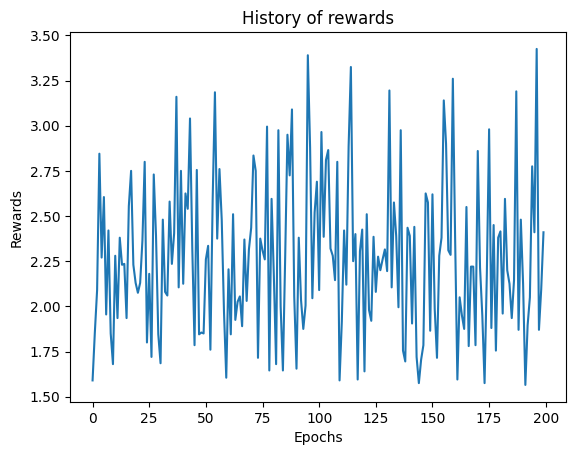

In [69]:
plt.plot(rewards)
plt.title("History of rewards")
plt.xlabel("Epochs")
plt.ylabel("Rewards")
plt.show()

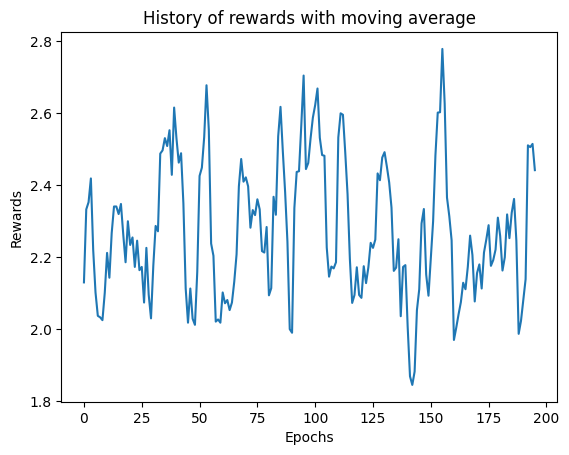

In [70]:
plt.plot([(rewards[i]+rewards[i-1]+ rewards[i+1] + rewards[i+2] + rewards[i-2])/5 for i in range(2, len(rewards)-2)])
plt.title("History of rewards with moving average")
plt.xlabel("Epochs")
plt.ylabel("Rewards")
plt.show()

#Let's look have the agent acts

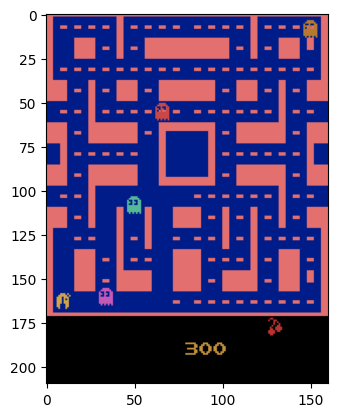

In [91]:
from IPython import display
state, _ = env.reset()
for t in range(500):
  action = policy_greedy(torch.tensor(state, dtype=torch.float).unsqueeze(0) ,EPS, Q_net)
  new_s, r, terminated, truncated, _ = env.step(action)
  plt.imshow(env.render())
  display.display(plt.gcf())
  display.clear_output(wait=True)
  if terminated or truncated:
    break

# Conclusions
The agent acts well. Sometimes it seems that the agent even deliberately avoids ghosts.

Ideas:
* Make validation games. We teach the model from random point, so rewards can be lower for real start point.
* Limit the space, that environment returns, to the game area.